In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely import box


from pystac_client import Client
import planetary_computer

import odc.stac
from IPython.display import Image

## Fire perimeters exploration

<Axes: >

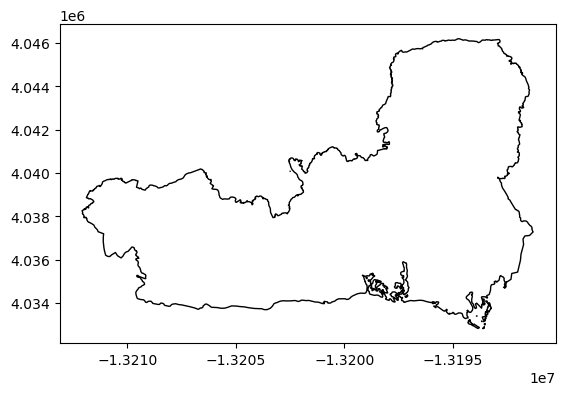

In [9]:
palisades = gpd.read_file(os.path.join('data', 'Palisades_Perimeter_20250121', 'Palisades_Perimeter_20250121.shp'))
palisades.plot(color='None')

<Axes: >

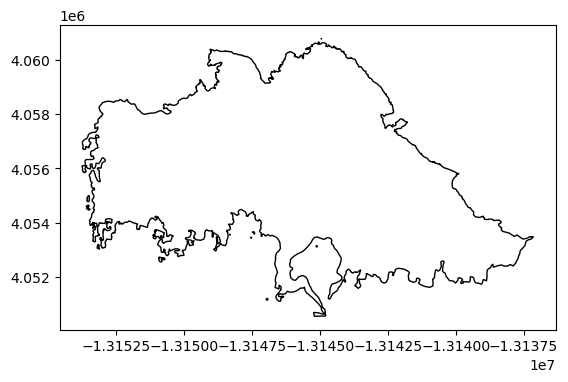

In [10]:
eaton = gpd.read_file(os.path.join('data', 'Eaton_Perimeter_20250121', 'Eaton_Perimeter_20250121.shp'))
eaton.plot(color='None')

In [4]:
print(eaton.crs)
print(palisades.crs)

EPSG:3857
EPSG:3857


## Retrieve Landsat imagery

Look for Landsat 2 imagery over the Eaton and Pallisades fire during February 2025. The fires took place during January 2025.

In [5]:
palisades_bbox = palisades.to_crs('epsg:4326').total_bounds.tolist()  # [minx, miny, maxx, maxy]
print(palisades_bbox)

[-118.68616028345444, 34.029938999912595, -118.49943999984302, 34.129359000207145]


In [6]:
# GET ITEM
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook

# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Temporal range of interest
time_range = "2025-02-02/2025-02-27"

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=palisades_bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")


Returned 4 Items


In [9]:
item = items[0]
Image(url=item.assets["rendered_preview"].href, width=500)

In [10]:
item = items[1]
Image(url=item.assets["rendered_preview"].href, width=500)

In [11]:
item = items[2]
Image(url=item.assets["rendered_preview"].href, width=500)

In [12]:
item = items[3]
Image(url=item.assets["rendered_preview"].href, width=500)

In [7]:
for item in items:
    print(item.datetime)

# Selected Febryary 23 item for analysis
item = items[1]

2025-02-23 18:28:37.542408+00:00
2025-02-23 18:28:13.651369+00:00
2025-02-15 18:28:55.387569+00:00
2025-02-15 18:28:31.496552+00:00


## Subset bands
The data is too big and for this exercise we only need red, green, blue, near-infrared and short-wave infrared.

More information on Landsat bands:
https://www.usgs.gov/media/images/common-landsat-band-combinations
https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites

In [8]:
# Item assets
max_key_length = len(max(item.assets, key=len))
for key in item.assets.keys():
    print(f"{key.rjust(max_key_length)} -- {item.assets[key].title}")

              qa -- Surface Temperature Quality Assessment Band
             ang -- Angle Coefficients File
             red -- Red Band
            blue -- Blue Band
            drad -- Downwelled Radiance Band
            emis -- Emissivity Band
            emsd -- Emissivity Standard Deviation Band
            trad -- Thermal Radiance Band
            urad -- Upwelled Radiance Band
           atran -- Atmospheric Transmittance Band
           cdist -- Cloud Distance Band
           green -- Green Band
           nir08 -- Near Infrared Band 0.8
          lwir11 -- Surface Temperature Band
          swir16 -- Short-wave Infrared Band 1.6
          swir22 -- Short-wave Infrared Band 2.2
         coastal -- Coastal/Aerosol Band
         mtl.txt -- Product Metadata File (txt)
         mtl.xml -- Product Metadata File (xml)
        mtl.json -- Product Metadata File (json)
        qa_pixel -- Pixel Quality Assessment Band
       qa_radsat -- Radiometric Saturation and Terrain Occlusion Qua

In [9]:
bands_of_interest = ['red', 'green', 'blue', 'nir08', 'swir22']
raw_data = odc.stac.stac_load(
    [item], bands=bands_of_interest
).isel(time=0)
raw_data

<xarray.Dataset> Size: 612MB
Dimensions:      (y: 7891, x: 7751)
Coordinates:
  * y            (y) float64 63kB 3.949e+06 3.949e+06 ... 3.712e+06 3.712e+06
  * x            (x) float64 62kB 2.625e+05 2.625e+05 ... 4.95e+05 4.95e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
Data variables:
    red          (y, x) uint16 122MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    green        (y, x) uint16 122MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    blue         (y, x) uint16 122MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nir08        (y, x) uint16 122MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    swir22       (y, x) uint16 122MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [19]:
for var in ["red", "green", "blue", "nir08", "swir22"]:
    raw_data = raw_data.assign({var: raw_data[var].astype("int32")})
raw_data

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 7891, x: 7751)
Coordinates:
  * y            (y) float64 63kB 3.949e+06 3.949e+06 ... 3.712e+06 3.712e+06
  * x            (x) float64 62kB 2.625e+05 2.625e+05 ... 4.95e+05 4.95e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
Data variables:
    red          (y, x) int32 245MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    green        (y, x) int32 245MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    blue         (y, x) int32 245MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nir08        (y, x) int32 245MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    swir22       (y, x) int32 245MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

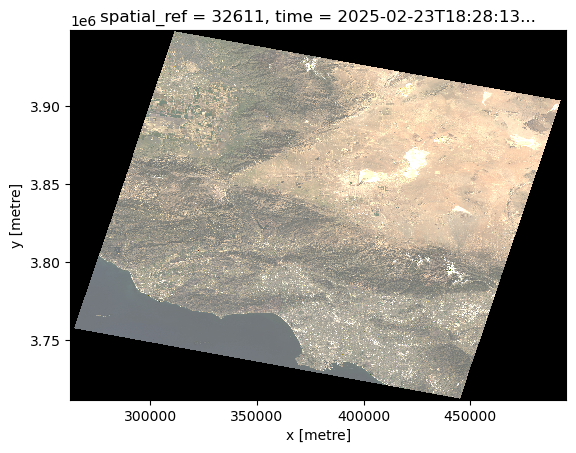

In [20]:
# Plot true color image 
raw_data[['red','green','blue']].to_array().plot.imshow(robust=True)

In [21]:
# Save intermediate output since previous band selection takes time
# THIS IS NOT PROPERLY SAVED: THE GEOREFERENCE IS LOST
raw_data.to_netcdf(os.path.join('data','landsat8-2025-02-23-LA-simplified.nc'))

In [ ]:
# Plot true color image 
raw_data[['red','green','blue']].to_array().plot.imshow(robust=True)

## False color imagery with fire perimeters

<Axes: title={'center': 'spatial_ref = 32611, time = 2025-02-23T18:28:13...'}, xlabel='x [metre]', ylabel='y [metre]'>

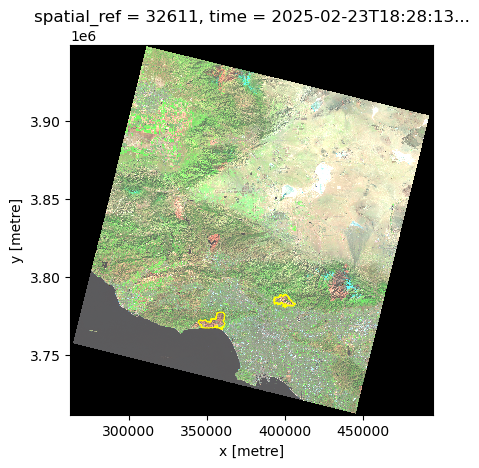

In [17]:
fig, ax = plt.subplots()
raw_data[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust=True)

palisades.to_crs(raw_data.rio.crs).plot(ax=ax, color='none', edgecolor='yellow', linewidth = 0.8)
eaton.to_crs(raw_data.rio.crs).plot(ax=ax, color='none', edgecolor='yellow', linewidth = 0.8)

## Data clipping

False color iamgery is ok, but the perimeters are too small relative to the scene extension. So I will clip the scene to a more reasonable area of interest.

In [34]:
# Merge files into single geodataframe for ease of processing
fires = pd.concat([eaton, palisades], ignore_index=True)

# Create fires bounding box
fires_bbox = (fires
                .to_crs(raw_data.rio.crs)
                .total_bounds
                )

fires_bbox = gpd.GeoDataFrame(geometry = [box(*fires_bbox)],
                             crs = raw_data.rio.crs)

geometry
0  POLYGON ((406646.849 3766517.468, 406646.849 3...

<Axes: title={'center': 'spatial_ref = 32611, time = 2025-02-23T18:28:13...'}, xlabel='x [metre]', ylabel='y [metre]'>

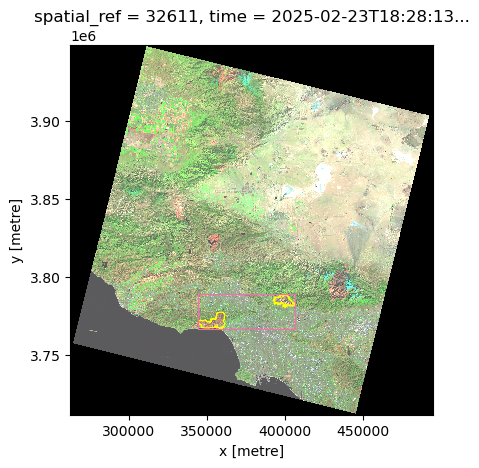

In [38]:
# Examine fire scars, perimeters and bounding box on false color image 
fig, ax = plt.subplots()
raw_data[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust=True)

fires.to_crs(raw_data.rio.crs).plot(ax=ax, color='none', edgecolor='yellow', linewidth = 0.8)
fires_bbox.plot(ax=ax, color='none', edgecolor='hotpink', linewidth=0.8)


<Axes: title={'center': 'spatial_ref = 32611, time = 2025-02-23T18:28:13...'}, xlabel='x [metre]', ylabel='y [metre]'>

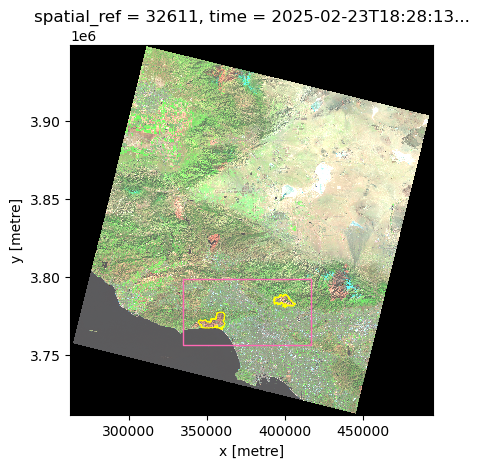

In [47]:
# Fire perimeters, scars, and a 10,000 m buffer around bbox on false color iamage
fig, ax = plt.subplots()

raw_data[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust=True)

fires.to_crs(raw_data.rio.crs).plot(ax=ax, color='none', edgecolor='yellow', linewidth = 0.8)
fires_bbox.buffer(10000, join_style='mitre').plot(ax=ax, color='none', edgecolor='hotpink', linewidth = 1)

In [48]:
# Clip raster data to 10,000m buffer around fire perimeters bbox
aoi = raw_data.rio.clip(fires_bbox.buffer(10000, join_style='mitre'))

New plots with clipped raster

<Axes: title={'center': 'time = 2025-02-23T18:28:13.651369, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

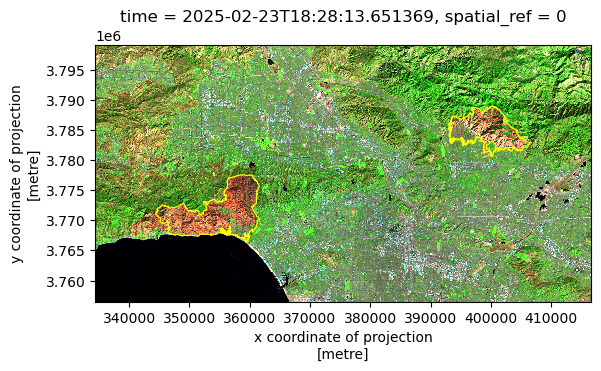

In [50]:
fig, ax = plt.subplots()

aoi[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust=True)
fires.to_crs(raw_data.rio.crs).plot(ax=ax, color='none', edgecolor='yellow', linewidth = 0.8)

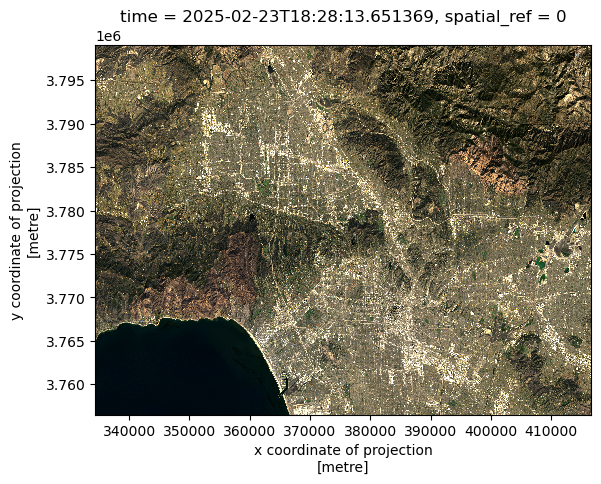

In [51]:
aoi[['red','green','blue']].to_array().plot.imshow(robust=True)

## Save data and confirm

Had to install netCDF4 in the EDS-220 env to write the data:
`conda install -c conda-forge netCDF4`

Had to install in the EDS-220 env to read in data:
`conda install -c conda-forge libgdal-hdf5`

**Writing and reading needs to be fixed: the geo-referencing is lost. `spatial_ref` coordinate is 0.**

In [55]:
# Save intermediate output since previous band selection takes time
aoi.to_netcdf(os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc'))

In [8]:
data = rioxr.open_rasterio(os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc'))
data

/Users/galaz-garcia/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/galaz-garcia/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/galaz-garcia/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/galaz-garcia/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset

<xarray.Dataset> Size: 39MB
Dimensions:      (band: 1, x: 2742, y: 1418)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 22kB 0.5 1.5 2.5 ... 2.74e+03 2.74e+03 2.742e+03
  * y            (y) float64 11kB 0.5 1.5 2.5 ... 1.416e+03 1.416e+03 1.418e+03
    spatial_ref  int64 8B 0
Data variables:
    blue         (band, y, x) uint16 8MB ...
    green        (band, y, x) uint16 8MB ...
    nir08        (band, y, x) uint16 8MB ...
    red          (band, y, x) uint16 8MB ...
    swir22       (band, y, x) uint16 8MB ...
Attributes: (12/65)
    blue_coordinates:                              time
    blue_grid_mapping:                             spatial_ref
    blue__FillValue:                               0
    blue__Netcdf4Coordinates:                      0 1
    green_coordinates:                             time
    green_grid_mapping:                            spatial_ref
    ...                                            ...
    y_standard_name:                               projection_y_coordinate
    y_units:                                       metre
    y__FillValue:                                  nan
    y__Netcdf4Coordinates:                         0
    y__Netcdf4Dimid:                               0
    _NCProperties:                                 version=2,netcdf=4.9.3,hdf...

## Confirm data prep from saved raster

In [7]:
read_in_data = xr.open_dataset(os.path.join('data','landsat8-2025-02-23-LA-simplified.nc'))
read_in_data

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 7891, x: 7751)
Coordinates:
  * y            (y) float64 63kB 3.949e+06 3.949e+06 ... 3.712e+06 3.712e+06
  * x            (x) float64 62kB 2.625e+05 2.625e+05 ... 4.95e+05 4.95e+05
    spatial_ref  int32 4B ...
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) int32 245MB ...
    green        (y, x) int32 245MB ...
    blue         (y, x) int32 245MB ...
    nir08        (y, x) int32 245MB ...
    swir22       (y, x) int32 245MB ...

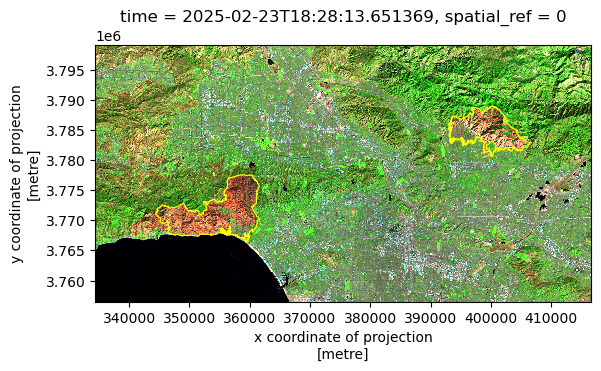

In [12]:
# Merge files into single geodataframe for ease of processing
fires = pd.concat([eaton, palisades], ignore_index=True)

# Create fires bounding box
fires_bbox = (fires
                .to_crs(read_in_data.rio.crs)
                .total_bounds
                )

fires_bbox = gpd.GeoDataFrame(geometry = [box(*fires_bbox)],
                             crs = read_in_data.rio.crs)

# Clip raster data to 10,000m buffer around fire perimeters bbox
aoi = read_in_data.rio.clip(fires_bbox.buffer(10000, join_style='mitre'))

fig, ax = plt.subplots()

aoi[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust=True)
fires.to_crs(read_in_data.rio.crs).plot(ax=ax, color='none', edgecolor='yellow', linewidth = 0.8)

plt.show()

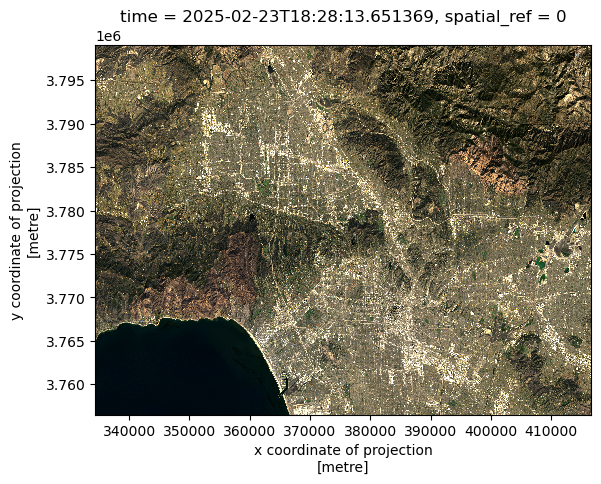

In [13]:
aoi[['red','green','blue']].to_array().plot.imshow(robust=True)

In [14]:
aoi

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) int32 16MB 10242 9886 10142 9940 ... 10327 10188 9967
    green        (y, x) int32 16MB 9930 9687 9894 9746 ... 9774 10176 9984 9662
    blue         (y, x) int32 16MB 9290 9183 9344 9181 ... 9284 9624 9490 9187
    nir08        (y, x) int32 16MB 13306 13132 13282 13182 ... 14271 12870 13063
    swir22       (y, x) int32 16MB 14298 14372 14966 14504 ... 14191 14061 13291